## 1. Imports et Configuration

In [2]:
import pandas as pd
import numpy as np
import re
import itertools
import warnings

# IMPORTS VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns


# IMPORTS NLP ET PRÉTRAITEMENT
from bs4 import BeautifulSoup
from bs4 import XMLParsedAsHTMLWarning
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Téléchargements NLTK
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)


# IMPORTS SCIKIT-LEARN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD

# Configuration
warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)
plt.style.use('seaborn-v0_8-whitegrid')



## 2. Chargement des Données

In [3]:
# Chargement des 50 000 questions qualitatives extraites via SQL (StackExchange Data Explorer)
# Filtres appliqués : Score > 10, ViewCount > 1000, 5 tags minimum.
df = pd.read_csv('./data/stack_overflow_brut.csv', encoding='utf-8')

print(f" Dataset chargé : {df.shape[0]} questions, {df.shape[1]} colonnes")
print(f"\nColonnes disponibles : {df.columns.tolist()}")
df.head()

 Dataset chargé : 50000 questions, 8 colonnes

Colonnes disponibles : ['Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount', 'AnswerCount']


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Paging a collection with LINQ,<p>How do you page through a collection in LIN...,<linq><.net-3.5>,66,89,6472,NaN,4
1,How do I add existing comments to RDoc in Ruby?,<p>I want to format my existing comments as 'R...,<ruby><rdoc>,72,48,2249,NaN,2
2,Getting Subclipse in Aptana to work with the n...,<p>The version of <strong>Subclipse (1.2.4)</s...,<eclipse><svn><aptana><subclipse>,79,50,11526,NaN,4
3,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,<apache-flex><actionscript-3><air>,80,54,6789,NaN,3
4,Flat file databases,<p>What are the best practices around creating...,<php><sql><database><flat-file>,85,133,70890,NaN,11


## 3. Analyse Exploratoire (EDA)

### 3.1 Analyse Univariée

In [4]:
# Informations générales sur le dataset

print("INFORMATIONS GÉNÉRALES")
print(f"\nNombre de questions : {len(df)}")
print(f"\nValeurs manquantes :")
print(df.isnull().sum())
print(f"\nTypes de données :")
print(df.dtypes)

INFORMATIONS GÉNÉRALES

Nombre de questions : 50000

Valeurs manquantes :
Title                0
Body                 0
Tags                 0
Id                   0
Score                0
ViewCount            0
FavoriteCount    50000
AnswerCount          0
dtype: int64

Types de données :
Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object


In [4]:
# Statistiques descriptives
df.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,5.000000e+04,0.0,50000.000000
mean,7.401014e+06,16.49088,1.685848e+04,NaN,3.013700
std,4.155300e+06,148.60471,1.101925e+05,NaN,4.196621
min,1.400000e+01,-28.00000,1.500000e+01,NaN,0.000000
25%,9.572703e+06,0.00000,4.830000e+02,NaN,1.000000
50%,9.658457e+06,1.00000,1.550000e+03,NaN,2.000000
75%,9.744819e+06,5.00000,5.240250e+03,NaN,3.000000
max,1.013820e+07,9766.00000,6.186109e+06,NaN,296.000000


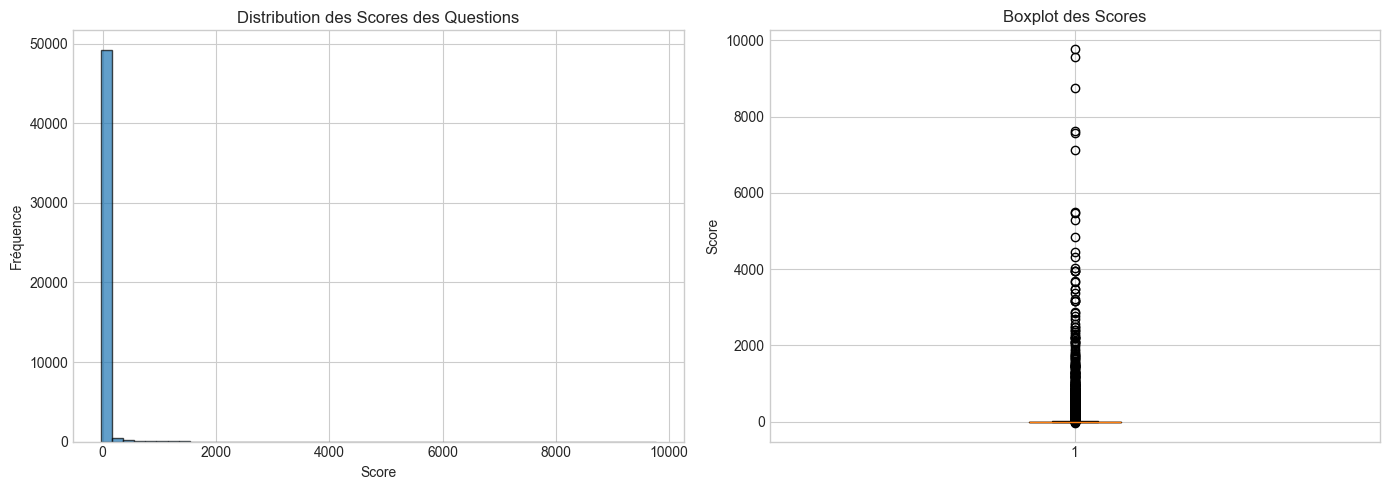


Statistiques des scores :
  - Moyenne : 16.49
  - Médiane : 1.00
  - Écart-type : 148.60


In [5]:
# Distribution des scores (si disponible)
if 'Score' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogramme des scores
    axes[0].hist(df['Score'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Fréquence')
    axes[0].set_title('Distribution des Scores des Questions')
    
    # Boxplot des scores
    axes[1].boxplot(df['Score'])
    axes[1].set_ylabel('Score')
    axes[1].set_title('Boxplot des Scores')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nStatistiques des scores :")
    print(f"  - Moyenne : {df['Score'].mean():.2f}")
    print(f"  - Médiane : {df['Score'].median():.2f}")
    print(f"  - Écart-type : {df['Score'].std():.2f}")

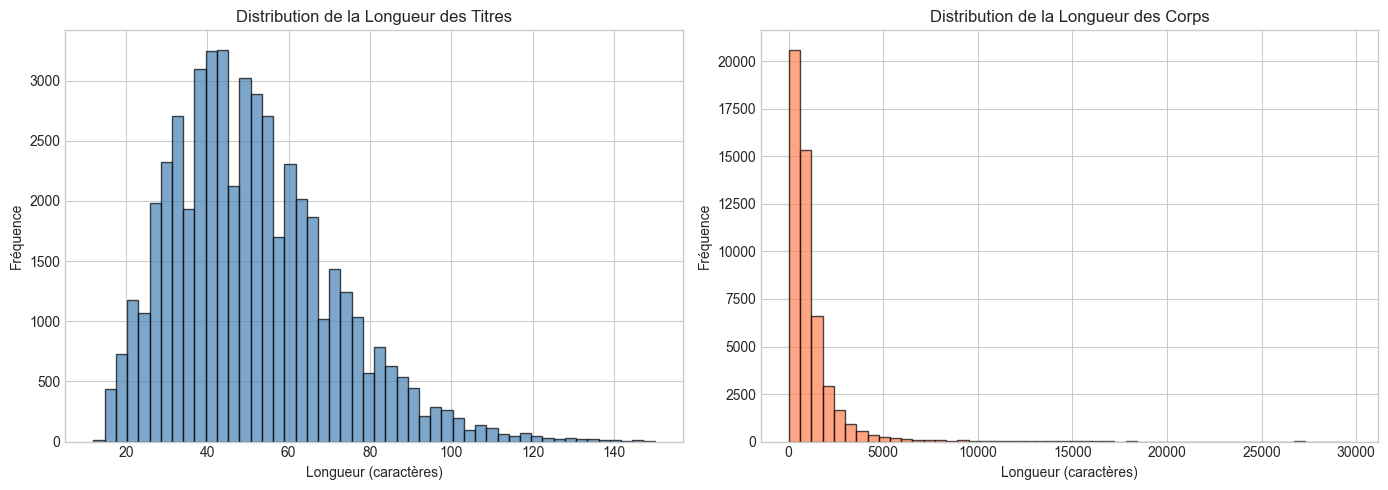


Longueur moyenne des titres : 51 caractères
Longueur moyenne des corps : 1138 caractères


In [6]:
# Analyse de la longueur des textes
df['title_length'] = df['Title'].apply(lambda x: len(str(x)))
df['body_length'] = df['Body'].apply(lambda x: len(str(x)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['title_length'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Longueur (caractères)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de la Longueur des Titres')

axes[1].hist(df['body_length'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Longueur (caractères)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution de la Longueur des Corps')

plt.tight_layout()
plt.show()

print(f"\nLongueur moyenne des titres : {df['title_length'].mean():.0f} caractères")
print(f"Longueur moyenne des corps : {df['body_length'].mean():.0f} caractères")

### 3.2 Analyse des Tags

In [7]:
# Extraction des tags depuis le format HTML <tag1><tag2><tag3>
def extract_tags(tags_str):
    """Extrait la liste de tags à partir de la chaîne HTML."""
    if not isinstance(tags_str, str):
        return []
    return [tag.strip() for tag in tags_str.strip('<>').split('><') if tag.strip()]

df['Tags_List'] = df['Tags'].apply(extract_tags)
df['num_tags'] = df['Tags_List'].apply(len)

print(f"Nombre moyen de tags par question : {df['num_tags'].mean():.2f}")
print(f"Nombre min de tags : {df['num_tags'].min()}")
print(f"Nombre max de tags : {df['num_tags'].max()}")

Nombre moyen de tags par question : 2.91
Nombre min de tags : 1
Nombre max de tags : 6


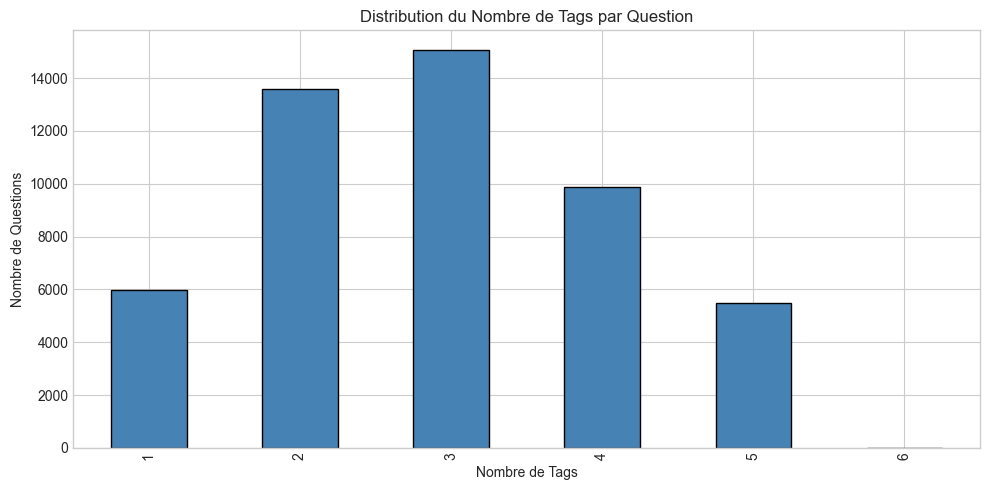

In [8]:
# Distribution du nombre de tags
plt.figure(figsize=(10, 5))
df['num_tags'].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Nombre de Tags')
plt.ylabel('Nombre de Questions')
plt.title('Distribution du Nombre de Tags par Question')
plt.tight_layout()
plt.show()


Nombre total de tags uniques : 10974
Nombre total d'occurrences de tags : 145282


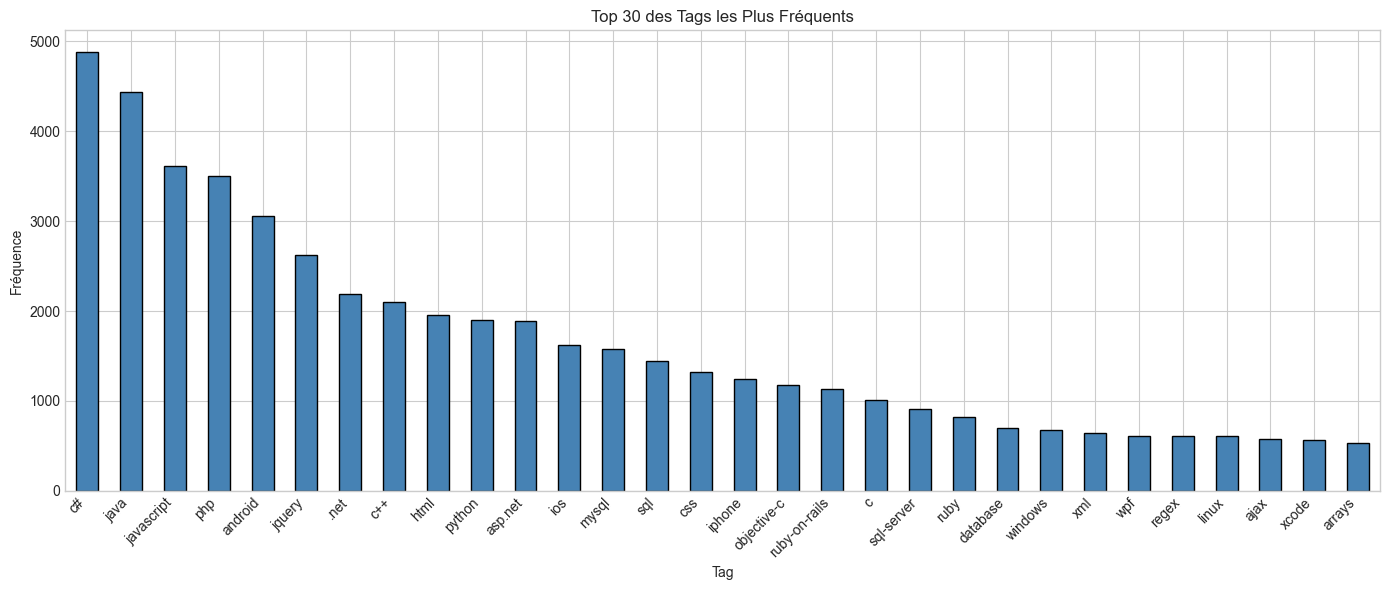

In [9]:
# Top 30 des tags les plus fréquents
all_tags = list(itertools.chain.from_iterable(df['Tags_List']))
tags_counts = pd.Series(all_tags).value_counts()

print(f"\nNombre total de tags uniques : {len(tags_counts)}")
print(f"Nombre total d'occurrences de tags : {len(all_tags)}")

plt.figure(figsize=(14, 6))
tags_counts.head(30).plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Tag')
plt.ylabel('Fréquence')
plt.title('Top 30 des Tags les Plus Fréquents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.3 Analyse Multivariée

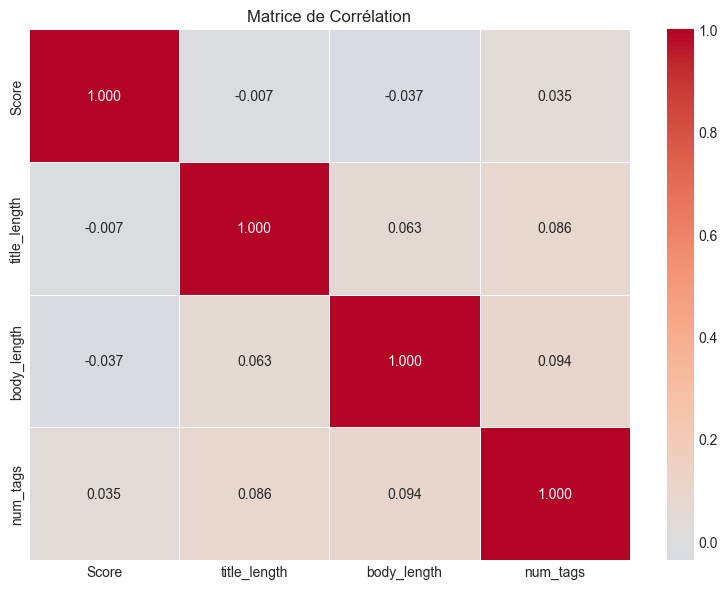

In [10]:
# Corrélation entre score et longueur du texte
if 'Score' in df.columns:
    correlation_matrix = df[['Score', 'title_length', 'body_length', 'num_tags']].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.3f', linewidths=0.5)
    plt.title('Matrice de Corrélation')
    plt.tight_layout()
    plt.show()

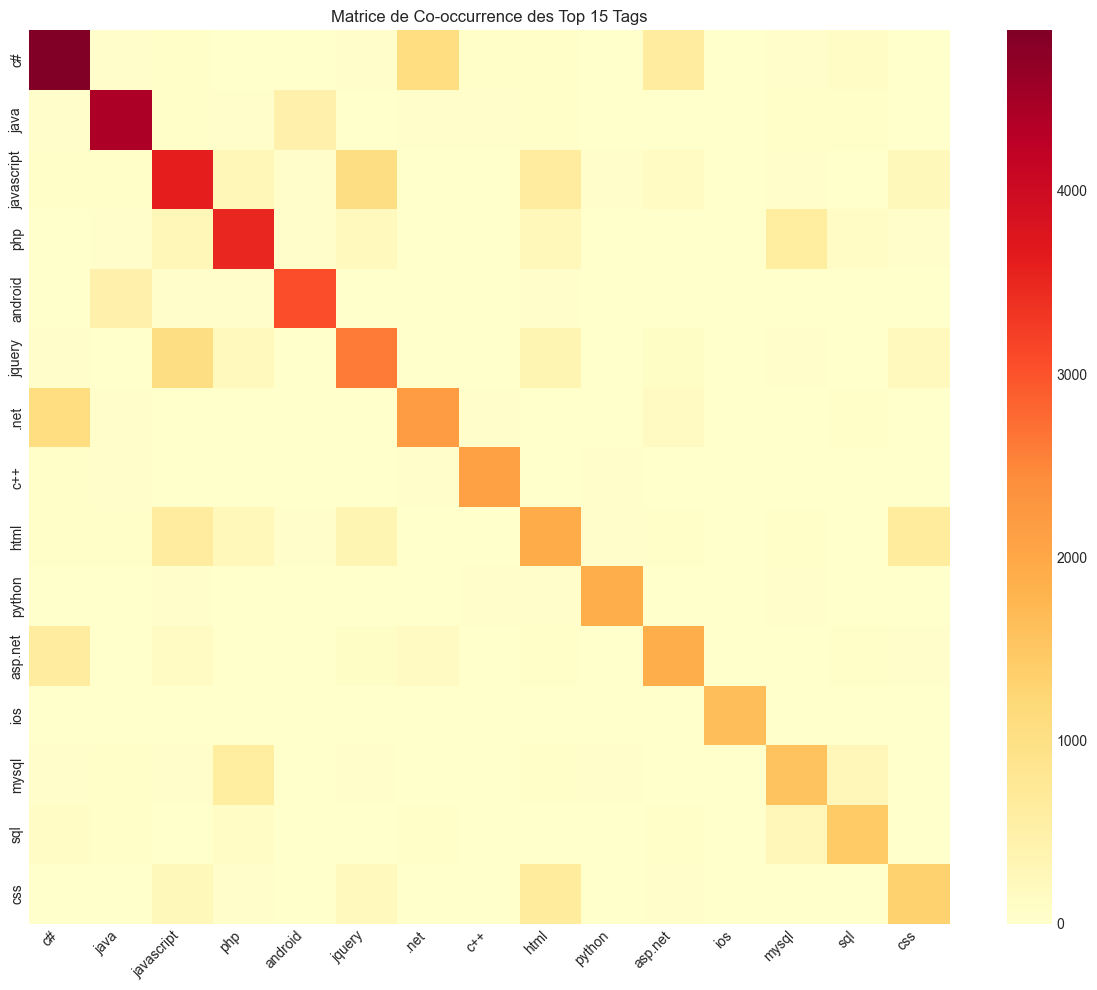

In [11]:
# Co-occurrence des tags (top tags)
from collections import Counter

# Sélectionner les 15 tags les plus fréquents
top_tags = tags_counts.head(15).index.tolist()

# Créer une matrice de co-occurrence
cooccurrence = np.zeros((len(top_tags), len(top_tags)))

for tags_list in df['Tags_List']:
    tags_in_top = [t for t in tags_list if t in top_tags]
    for i, tag1 in enumerate(top_tags):
        for j, tag2 in enumerate(top_tags):
            if tag1 in tags_in_top and tag2 in tags_in_top:
                cooccurrence[i, j] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, xticklabels=top_tags, yticklabels=top_tags, 
            cmap='YlOrRd', annot=False)
plt.title('Matrice de Co-occurrence des Top 15 Tags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Nettoyage des Données

### 4.1 Nettoyage HTML

In [13]:
def clean_html_and_code(text):
    """
    Supprime les balises HTML et extrait le texte brut.
    Ceci est VITAL car le 'Body' Stack Overflow est en HTML.
    """
    if not isinstance(text, str):
        return ""
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text(separator=' ')
    cleaned_text = re.sub('\n', ' ', cleaned_text)
    return cleaned_text

# Création du texte combiné (Titre + Corps)
df['Text_Raw'] = df['Title'] + " " + df['Body']

# Application du nettoyage HTML
print("Nettoyage du HTML en cours...")
df['Text_Cleaned'] = df['Text_Raw'].apply(clean_html_and_code)

print("\n Nettoyage HTML terminé")
print(f"\nExemple de texte nettoyé :")
print(df['Text_Cleaned'].iloc[0][:500])

Nettoyage du HTML en cours...

 Nettoyage HTML terminé

Exemple de texte nettoyé :
Paging a collection with LINQ  How do you page through a collection in LINQ given that you have a  startIndex  and a  count ?  


### 4.2 Nettoyage Linguistique (Tokenization, Stopwords, Lemmatization)

In [14]:
# Définition des fonctions de prétraitement

def tokenizer_fct(sentence):
    """Tokenize en remplaçant les caractères spéciaux."""
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words):
    """Filtre les stopwords et mots courts."""
    filtered_w = [w for w in list_words if w not in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

def lower_start_fct(list_words):
    """Lowercase et filtre les mentions/URLs."""
    lw = [w.lower() for w in list_words 
        if (not w.startswith("@")) and (not w.startswith("http"))]
    return lw

def lemma_fct(list_words):
    """Lemmatization des mots."""
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction complète pour Bag-of-Words avec lemmatization
def transform_bow_lem_fct(desc_text):
    """Pipeline complet de prétraitement pour BoW/LDA/Word2Vec."""
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction pour Deep Learning (sans lemmatization, garde plus de contexte)
def transform_dl_fct(desc_text):
    """Prétraitement léger pour BERT/USE."""
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

print(" Fonctions de prétraitement définies")

 Fonctions de prétraitement définies


In [15]:
# Application du prétraitement
print("Application du prétraitement linguistique...")

# Pour les approches classiques (BoW, TF-IDF, Word2Vec, LDA)
df['Tokens_LDA'] = df['Text_Cleaned'].apply(transform_bow_lem_fct)

# Pour les approches Deep Learning (BERT, USE)
df['Tokens_DL'] = df['Text_Cleaned'].apply(transform_dl_fct)

print("\n Prétraitement terminé")
print("\n--- Vérification du Pipeline ---")
print(df[['Text_Cleaned', 'Tokens_LDA', 'Tokens_DL']].head(2))

Application du prétraitement linguistique...

 Prétraitement terminé

--- Vérification du Pipeline ---
                                        Text_Cleaned  \
0  Paging a collection with LINQ  How do you page...   
1  How do I add existing comments to RDoc in Ruby...   

                                          Tokens_LDA  \
0  paging collection linq how page collection lin...   
1  how add existing comment rdoc ruby want format...   

                                           Tokens_DL  
0  paging a collection with linq how do you page ...  
1  how do i add existing comments to rdoc in ruby...  


## 5. Feature Engineering : Bag-of-Words

### 5.1 Réduction de Dimension du Vocabulaire

In [26]:
# Création du vocabulaire avec TF-IDF
# max_features limite le vocabulaire aux N mots les plus fréquents

MAX_FEATURES = 20000  # Réduction de dimension du vocabulaire

tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_tfidf = tfidf_vectorizer.fit_transform(df['Tokens_LDA'])

print(f"\n Matrice TF-IDF créée")
print(f"   - Forme : {X_tfidf.shape} (questions x features)")
print(f"   - Vocabulaire réduit à {MAX_FEATURES} mots")
print(f"\nExemples de mots du vocabulaire :")
print(list(tfidf_vectorizer.vocabulary_.keys())[:20])


 Matrice TF-IDF créée
   - Forme : (50000, 20000) (questions x features)
   - Vocabulaire réduit à 20000 mots

Exemples de mots du vocabulaire :
['paging', 'collection', 'linq', 'how', 'page', 'given', 'startindex', 'count', 'add', 'existing', 'comment', 'rdoc', 'ruby', 'want', 'format', 'viewed', 'using', 'what', 'recommended', 'resource']


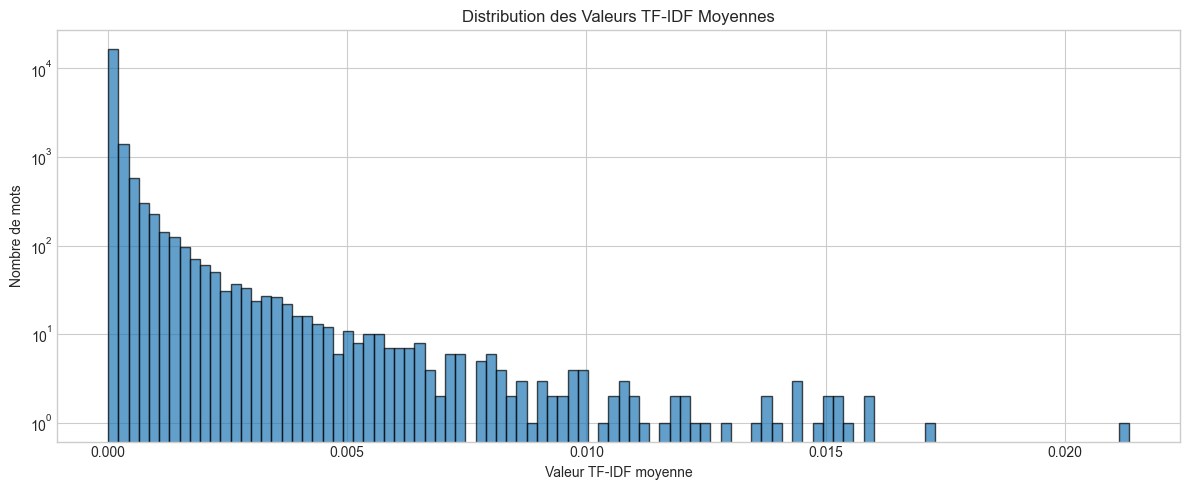

In [17]:
# Visualisation de la distribution des valeurs TF-IDF
tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()

plt.figure(figsize=(12, 5))
plt.hist(tfidf_means, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Valeur TF-IDF moyenne')
plt.ylabel('Nombre de mots')
plt.title('Distribution des Valeurs TF-IDF Moyennes')
plt.yscale('log')
plt.tight_layout()
plt.show()

### 5.2 Filtrage des Tags Rares

In [19]:
# Filtrage des tags rares pour la classification multi-label
# On ne peut pas classifier des tags qui apparaissent très rarement

TAG_MIN_COUNT = 50  # Seuil minimum d'apparitions

frequent_tags = tags_counts[tags_counts >= TAG_MIN_COUNT].index.tolist()

print(f"\n Réduction des Tags")
print(f"   - Tags totaux : {len(tags_counts)}")
print(f"   - Tags fréquents (>= {TAG_MIN_COUNT} occurrences) : {len(frequent_tags)}")
print(f"   - Réduction : {100 * (1 - len(frequent_tags)/len(tags_counts)):.1f}%")


 Réduction des Tags
   - Tags totaux : 10974
   - Tags fréquents (>= 50 occurrences) : 396
   - Réduction : 96.4%


In [20]:
# Filtrer les listes de Tags pour ne garder que les tags fréquents
df['Tags_Filtered'] = df['Tags_List'].apply(
    lambda tags: [tag for tag in tags if tag in frequent_tags]
)

# Vérification : combien de questions n'ont plus aucun tag après filtrage ?
questions_sans_tags = df['Tags_Filtered'].apply(lambda x: len(x) == 0).sum()
print(f"\nQuestions sans tags après filtrage : {questions_sans_tags} ({100*questions_sans_tags/len(df):.2f}%)")


Questions sans tags après filtrage : 3043 (6.09%)


In [22]:
# Création du MultiLabelBinarizer (Matrice Y des labels)
mlb = MultiLabelBinarizer()
Y_labels = mlb.fit_transform(df['Tags_Filtered'])

print(f"\n Matrice des Labels (Y) créée")
print(f"   - Forme : {Y_labels.shape} (questions x tags)")
print(f"   - Nombre de classes (tags) : {len(mlb.classes_)}")
print(f"\nExemples de tags disponibles :")
print(list(mlb.classes_[:30]))


 Matrice des Labels (Y) créée
   - Forme : (50000, 396) (questions x tags)
   - Nombre de classes (tags) : 396

Exemples de tags disponibles :
['.htaccess', '.net', '.net-2.0', '.net-3.5', '64-bit', 'actionscript', 'actionscript-3', 'active-directory', 'activerecord', 'ado.net', 'air', 'ajax', 'algorithm', 'amazon-ec2', 'amazon-web-services', 'android', 'android-activity', 'android-intent', 'android-layout', 'animation', 'ant', 'apache', 'apache-flex', 'architecture', 'arraylist', 'arrays', 'asp-classic', 'asp.net', 'asp.net-mvc', 'asp.net-mvc-3']


## 6. Sauvegarde des Données Prétraitées

In [25]:
# Sauvegarde du DataFrame prétraité pour les notebooks suivants
import os
import joblib

# Créer le dossier de sortie
os.makedirs('./data/processed', exist_ok=True)

# Sauvegarder le DataFrame
df.to_csv('./data/processed/df_preprocessed.csv', index=False)

# Sauvegarder le MultiLabelBinarizer
joblib.dump(mlb, './data/processed/mlb.pkl')

# Sauvegarder le vectorizer TF-IDF
joblib.dump(tfidf_vectorizer, './data/processed/tfidf_vectorizer.pkl')

print("\n Données sauvegardées dans ./data/processed/")
print("   - df_preprocessed.csv")
print("   - mlb.pkl")
print("   - tfidf_vectorizer.pkl")


 Données sauvegardées dans ./data/processed/
   - df_preprocessed.csv
   - mlb.pkl
   - tfidf_vectorizer.pkl


# 7. Résumé de l'analyse exploratoire

1. **Analyse Exploratoire** :
   - Distribution des scores, longueurs de texte
   - Analyse des tags (fréquence, co-occurrence)
   - Corrélations entre variables

2. **Nettoyage des Données** :
   - Suppression des balises HTML
   - Tokenization, stopwords, lemmatization
   - Deux versions : `Tokens_LDA` (complet) et `Tokens_DL` (léger)

3. **Feature Engineering** :
   - Vectorisation TF-IDF (20 000 features)
   - Filtrage des tags rares (>= 50 occurrences)
   - Réduction SVD optionnelle
